# NERF-like image generation

This notebook demonstrates a simple task of training a network to generate a single image. The network takes inputs in form $x,y$, transforms them through a positional encoder, and passes them through an MLP to generate RGB values. An L^2 loss is used to compare the network output to the target image.

In [2]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


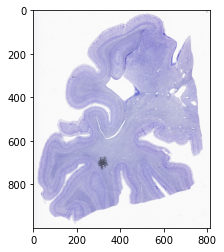

In [4]:
# Read an image of a histology slide
img_a = sitk.ReadImage('data/slide_4431_x16_1000.tiff')
plt.imshow(sitk.GetArrayFromImage(img_a));

In [5]:
# Place the image in a tensor
T_fix = torch.tensor(sitk.GetArrayFromImage(img_a), device=device, dtype=torch.float32)
T_fix = T_fix.permute(2,0,1)[None,:,:,:]
T_fix = T_fix / 255.0

In [6]:
# Create a network that maps coordinate (x,y) to an RGB value using
# sinusoidal positional embedding and an MLP
class MyNerf(torch.nn.Module):

    def __init__(self, enc_size=5, depth=4, width=128):
        super().__init__()

        # Construct the sinusoidal encoder weights
        self.register_buffer('omega', 2**torch.arange(enc_size) * torch.pi)

        # Create an MLP with 'depth' layers
        self.mlp = torch.nn.Sequential()
        self.mlp.add_module('dense_0', torch.nn.Linear(enc_size * 4 + 2, width))
        self.mlp.add_module('relu_0', torch.nn.ReLU())

        for i in range(1, depth-1):
            self.mlp.add_module(f'dense_{i}', torch.nn.Linear(width, width))
            self.mlp.add_module(f'relu_{i}', torch.nn.ReLU())

        self.mlp.add_module(f'dense_{depth-1}', torch.nn.Linear(width, 3))

    def forward(self, x):

        # Apply encoding to x
        omega = self.get_buffer('omega')
        z = torch.einsum('i,jk->jki', omega, x)
        y = torch.cat([x, torch.flatten(torch.sin(z), 1), torch.flatten(torch.cos(z), 1)], 1)

        # Pass through MLP
        return self.mlp(y)


In [7]:
nerf = MyNerf(enc_size=6, depth=6, width=256)
nerf.to(device)

MyNerf(
  (mlp): Sequential(
    (dense_0): Linear(in_features=26, out_features=256, bias=True)
    (relu_0): ReLU()
    (dense_1): Linear(in_features=256, out_features=256, bias=True)
    (relu_1): ReLU()
    (dense_2): Linear(in_features=256, out_features=256, bias=True)
    (relu_2): ReLU()
    (dense_3): Linear(in_features=256, out_features=256, bias=True)
    (relu_3): ReLU()
    (dense_4): Linear(in_features=256, out_features=256, bias=True)
    (relu_4): ReLU()
    (dense_5): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [8]:
# Try to reconstruct the input image
opt = torch.optim.Adam(nerf.parameters(), lr=1e-4)
loss = torch.nn.MSELoss(reduction='mean')

In [9]:
# Generate a sampling grid for mini-batches
id_affine = torch.tensor([[[1,0,0],[0,1,0]]],dtype=torch.float32, device=device)
grid = F.affine_grid(id_affine, T_fix.shape, align_corners=False)
grid_flat = grid.permute(0,3,1,2).flatten(2).permute(0,2,1).squeeze()
grid_flat = (grid_flat + 1.0) / 2.0
grid_flat = grid_flat.to(device)

# Get the target rgb intensities
rgb_flat = T_fix.flatten(2).permute(0,2,1).squeeze()

In [10]:
batch_size = 1000
for epoch in range(20):

    # Shuffle the grid
    epoch_idx = torch.randperm(grid_flat.shape[0])
    batch_ranges = np.linspace(0, grid_flat.shape[0], int(grid_flat.shape[0] / batch_size), dtype=np.int32)

    # Iterate over batches
    epoch_loss = 0
    for i in range(len(batch_ranges) - 1):

        # Get the current coordinates
        mb_idx = epoch_idx[batch_ranges[i]:batch_ranges[i+1]]
        x = grid_flat[mb_idx,:]

        # Get the target intensities at this sample
        target_rgb = rgb_flat[mb_idx,:]

        # Get the model output at this sample
        opt.zero_grad()
        rgb = nerf.forward(x)

        # Compute loss and backprom
        obj = loss(rgb, target_rgb)
        obj.backward()
        opt.step()

        # Track epoch loss
        epoch_loss += obj.item()

    # Report the epoch loss
    epoch_loss /= len(batch_ranges) - 1
    print(f'Epoch {epoch:04d}   Loss: {epoch_loss}')

Epoch 0000   Loss: 0.03142934118707975
Epoch 0001   Loss: 0.0025219336359037295
Epoch 0002   Loss: 0.002081549770405723
Epoch 0003   Loss: 0.0019110276069158666
Epoch 0004   Loss: 0.0018150212234575992
Epoch 0005   Loss: 0.0017547249755201241
Epoch 0006   Loss: 0.0017013495760670875
Epoch 0007   Loss: 0.001665705499773914
Epoch 0008   Loss: 0.0016335621335325234
Epoch 0009   Loss: 0.0016030413745385078
Epoch 0010   Loss: 0.0015818298095837235
Epoch 0011   Loss: 0.0015584268122853964
Epoch 0012   Loss: 0.0015407373076649728
Epoch 0013   Loss: 0.001522520805829791
Epoch 0014   Loss: 0.001511942924655698
Epoch 0015   Loss: 0.0014950502257115772
Epoch 0016   Loss: 0.0014818285968453612
Epoch 0017   Loss: 0.0014702172754447402
Epoch 0018   Loss: 0.00145874582187928
Epoch 0019   Loss: 0.00145076846310087


In [11]:
# Perform inference - we need a full grid of x
with torch.no_grad():
    grid_rgb = nerf.forward(grid_flat)

In [12]:
inf = grid_rgb.reshape(1,T_fix.shape[2], T_fix.shape[3], 3).detach().cpu().numpy()
inf = np.clip(inf[0,:,:,:], 0., 1.)
img_inference = sitk.GetImageFromArray(inf, isVector=True)
img_inference.CopyInformation(img_a)

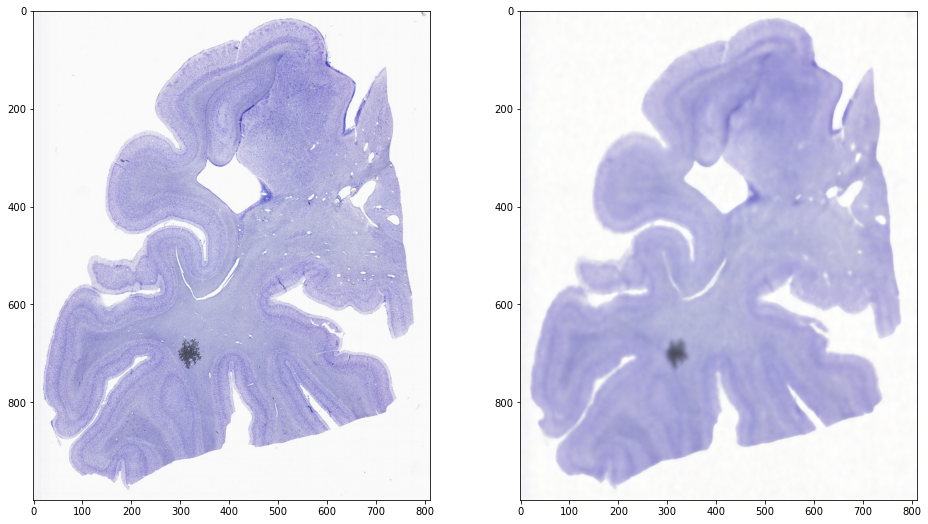

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(16,9));
ax[0].imshow(sitk.GetArrayFromImage(img_a));
ax[1].imshow(sitk.GetArrayFromImage(img_inference));

In [312]:
sum(p.numel() for p in nerf.parameters())


270851